# Initial settings

## Load libraries

In [122]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import re
from matplotlib.font_manager import FontProperties
import itertools
from StarbucksAnalysis.model import fit_logistic, pretty_coefficients
from StarbucksAnalysis.visualizations import group_and_smooth, plot_completion_lines, plot_completion_by_categorical
from StarbucksAnalysis.visualizations import plot_prediction_groups, expand_grid, OFFERS_PAL_DICT

## Data preparation

In [123]:
offers = pickle.load(open("processed_data/offers_cleaned.p", "rb"))

df_prop_age_gender = group_and_smooth(offers, ["gender", "age"])
df_prop_inc_gender = group_and_smooth(offers, ["gender", "income_thousands"])
df_prop_age_seniority = group_and_smooth(offers, ["seniority", "age"])
df_prop_income_seniority = group_and_smooth(offers, ["seniority", "income_thousands"])

customer_dems = offers.groupby("client_id").agg({"age": "mean", 
                                                 "income_thousands": "mean"})
customer_offers = offers.groupby(["client_id", "offer_type"])\
.agg({"offer_id": "count"})\
.reset_index()\
.rename(columns = {"offer_id": "n_offers"})





# Demographics and istributions

In [124]:
OFFERS_PAL_DICT

{'Discount': '#4F6BA7', 'Bogo': '#84A8C7', 'Informational': '#BBBFA2'}

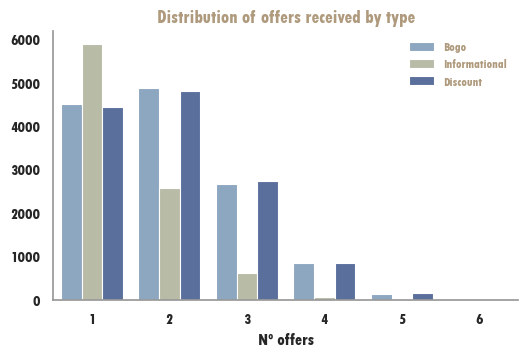

In [125]:
plt.subplots(figsize = (6, 3.5))

sns.set_context("paper", font_scale=1.5, rc={"font.size":16,"axes.titlesize":18,"axes.labelsize":16})



ax = plt.gca()
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.spines['left'].set_color('#999999')
ax.spines['bottom'].set_color('#999999')


sns.set_context("paper")
sns.despine()


sns.countplot(x = "n_offers",
              data = customer_offers, 
              hue = "offer_type", 
             palette = OFFERS_PAL_DICT, 
             edgecolor = "white")

ax.set(xlabel="Nº offers", ylabel= None)
plt.title("Distribution of offers received by type",  fontweight='bold', fontsize = 13)
plt.legend(loc='upper right', title = None, frameon=False)
plt.savefig("visualizations/distribution_of_offers.jpg", format = "jpg")
plt.show()



# Income and gender

## Distribution

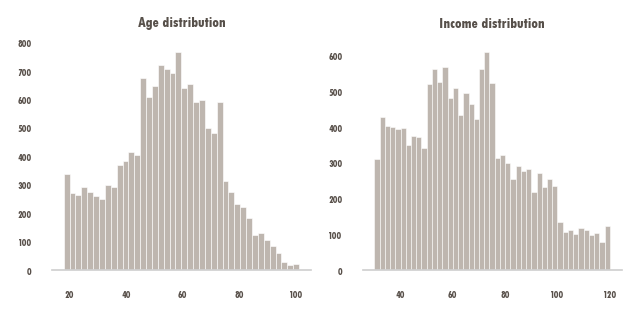

In [126]:
fig, ax = plt.subplots(1, 2, figsize = (4.2, 1.7), dpi = 175)

sns.histplot(data = customer_dems, 
            x = "age", 
            edgecolor = "white", 
            color = "#a89e94", 
            ax = ax[0], 
            bins = 40)

sns.histplot(data = customer_dems, 
            x = "income_thousands", 
            edgecolor = "white", 
            color = "#a89e94", 
            ax = ax[1], 
            bins = 45)

ax[0].set(title = "Age distribution", xlabel = "", ylabel = "")
ax[1].set(title = "Income distribution", xlabel = "", ylabel = "")
        

    
sns.despine()
    
for a in ax:
    
    a.xaxis.set_ticks_position('none')
    a.yaxis.set_ticks_position('none')
    a.spines['bottom'].set_color('#D0D0D0')
    a.spines['left'].set_color('#D0D0D0')
    a.tick_params(axis='both', colors='#58504a', labelsize=4)
    a.title.set_color("#57504a")
    a.title.set_size(6)
    a.spines["bottom"].set_linewidth(0.7)
    a.spines["left"].set_linewidth(0)

    
# for i, ax in enumerate(g.axes.flat):
#     if i > 0:
#         ax.yaxis.set_ticks_position('none')
#         ax.spines['left'].set_visible(False)

plt.savefig("visualizations/age_and_income_distribution.jpg", format = "jpg")

## Relation with offers

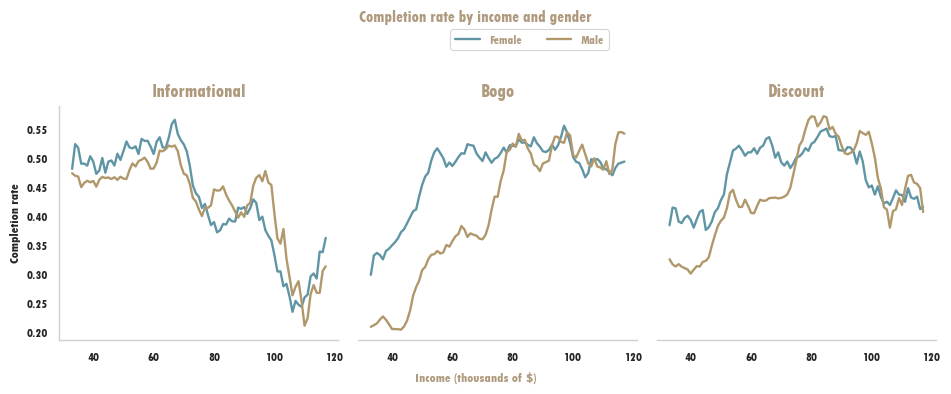

In [127]:
g = plot_completion_lines(df_prop_inc_gender.loc[df_prop_inc_gender.gender != "Other"], "income_thousands",  x_label = "Income (thousands of $)",
                      cat_var = "gender", palette = ["#6095a6", "#b0986b", "#899e9c"], 
                      title = "Completion rate by income and gender", 
                      linewidth = 1.7)

g.savefig("visualizations/prop_1_completed_by_income_and_gender.jpg", format = "jpg")



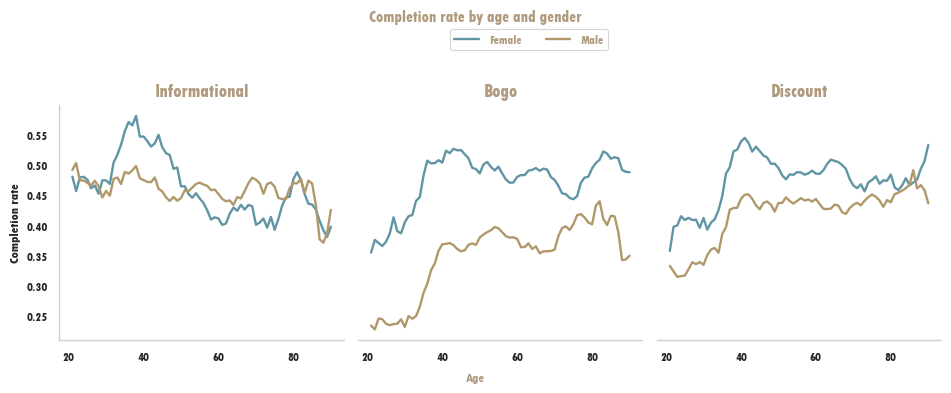

In [128]:
g = plot_completion_lines(df_prop_age_gender.loc[(df_prop_age_gender.age <= 90)  & (df_prop_age_gender.gender != "Other")], "age",  x_label = "Age",
                      cat_var = "gender", palette = ["#6095a6", "#b0986b", "#899e9c"], 
                      title = "Completion rate by age and gender",
                      linewidth = 1.7)

g.savefig("visualizations/prop_1_completed_by_age_and_gender.jpg", format = "jpg")

# Seniority

## Distribution

In [129]:
offers.groupby("seniority").agg({"age": ["mean", "std"],
                                                 "gender": lambda x: np.mean(x == "Female"), 
                                                 "income_thousands": ["mean", "std"]})

age               gender income_thousands           
                mean        std  <lambda>             mean        std
seniority                                                            
Gen1       51.436578  17.552988  0.233626        58.367601  17.406448
Gen2       56.159372  16.862593  0.487872        69.869743  22.179326
Gen3       53.456697  17.645297  0.384774        63.012863  21.140976

|  Seniority     |   Age |   % of Fem.   |   Income (thousands)   |
|-------|----|------|------|
| Gen 1 | 51 | 23 % | 58.4 |
| Gen 2 | 56 | 49 % | 70   |
| Gen 3 | 53 | 38 % | 63   |

## Distribution trhough time

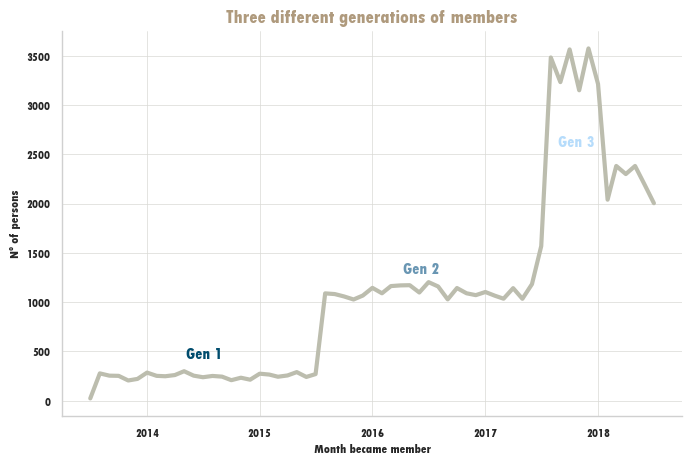

In [130]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.set(style="white", font = "TW Cen MT Condensed Extra Bold", 
       rc={"text.color": "#AF9A7D"})

client_month = pd.DataFrame(offers.groupby("month_member_on").count()["client_id"]).reset_index().rename(columns = {"client_id": "n"})
client_month["growth"] = client_month.n - client_month.n.shift(1)
 # client_month.head()
# client_month["f"] = client_month.client_id.apply(lambda x: x / sum(x))

g = sns.lineplot(data = client_month,
             x = "month_member_on", 
             y = "n", 
             color = "#bcbdae",
             linewidth = 3,
             ax = ax)

g.set(xlabel = "Month became member",
      ylabel = "Nº of persons")

plt.title("Three different generations of members", size = 14)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines['bottom'].set_color('#D0D0D0')
ax.spines['left'].set_color('#D0D0D0')
ax.grid(True, linestyle='-', linewidth=0.5, color='#d9d9d5')

ax.text(0.2, 0.15, "Gen 1", transform=ax.transAxes, color = "#004c6d")
ax.text(0.55, 0.37, "Gen 2", transform=ax.transAxes, color = "#6996b3")
ax.text(0.8, 0.7, "Gen 3", transform=ax.transAxes, color = "#b6dcfb")



sns.despine()

plt.savefig("visualizations/generations.jpg", format = "jpg")


# Income and age

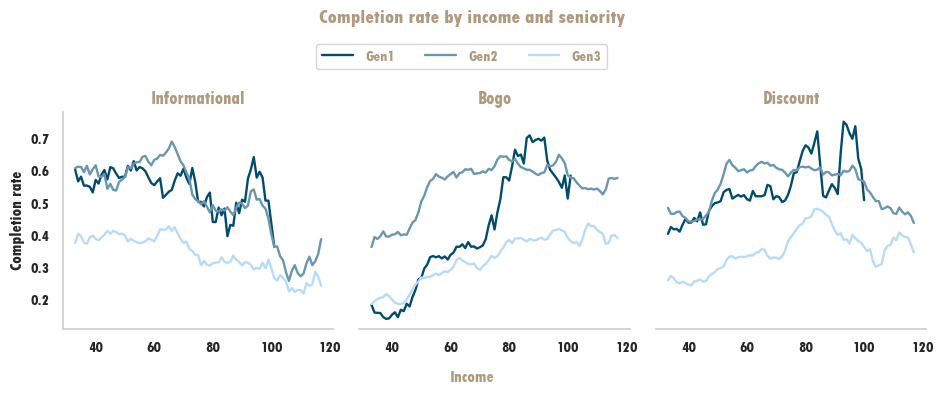

In [131]:


g = plot_completion_lines(df_prop_income_seniority, "income_thousands",  x_label = "Income",
                      cat_var = "seniority", palette = ["#004c6d", "#6996b3", "#b6dcfb"], 
                      title = "Completion rate by income and seniority",
                      linewidth = 1.7)

g.savefig("visualizations/prop_1_completed_by_income_and_seniority.jpg", format = "jpg")

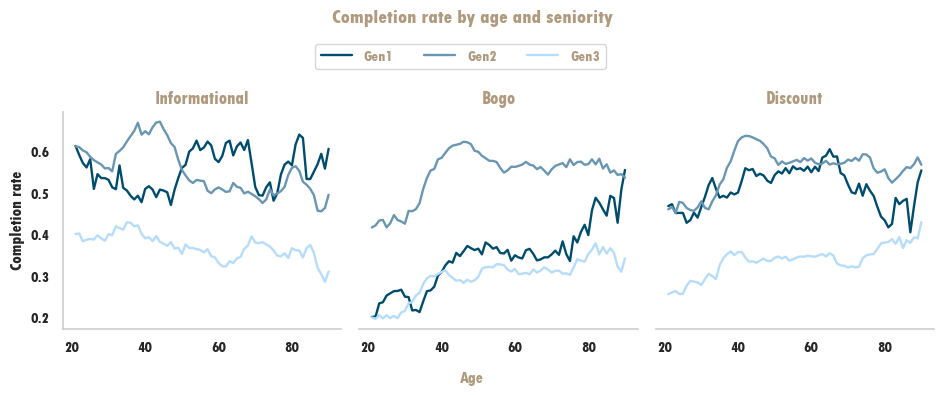

In [132]:
g = plot_completion_lines(df_prop_age_seniority.loc[df_prop_age_seniority.age <= 90], "age",  x_label = "Age",
                      cat_var = "seniority", palette = ["#004c6d", "#6996b3", "#b6dcfb"], 
                      title = "Completion rate by age and seniority",
                      linewidth = 1.7)

g.savefig("visualizations/prop_1_completed_by_age_and_seniority.jpg", format = "jpg")

## Gender

In [133]:
offers.gender

26809      Male
64637      Male
35889     Other
35888     Other
35887     Other
          ...  
45412      Male
17146    Female
17145    Female
45395      Male
13606    Female
Name: gender, Length: 66501, dtype: object

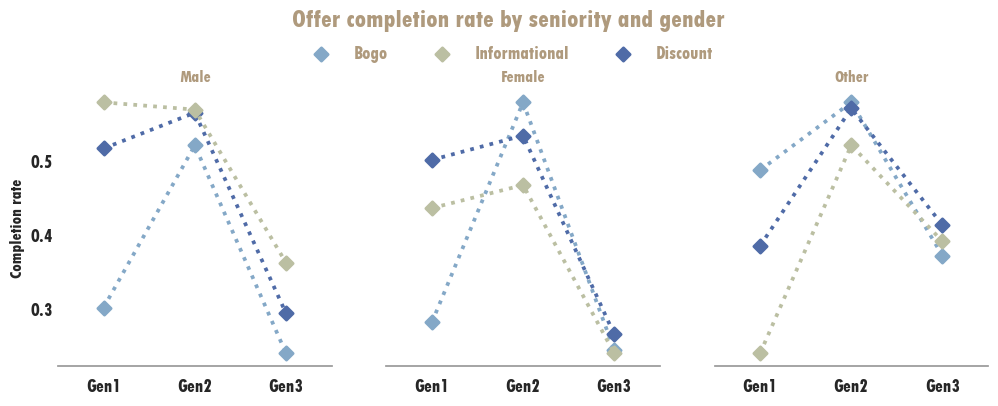

In [134]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for i, gender in enumerate(["Male", "Female", "Other"]):
    axis = ax[i]
    plot_completion_by_categorical(offers.loc[offers.gender == gender], "seniority", gender, ax=axis, join = True)
    
    # sns.despine(ax=axis)
    
    axis.xaxis.set_ticks_position('none')
    axis.yaxis.set_ticks_position('none')
    axis.spines['left'].set_visible(False)
    axis.tick_params(axis='y', length=0, labelsize = 13)
    axis.tick_params(axis='x', labelsize=13)
    axis.spines['bottom'].set_color('#999999')
    axis.set_xlabel(None)
   

    # remove legend
    axis.get_legend().remove()

    
    # remove y-axis label for the second and third plot
    if i > 0:
        axis.set_ylabel(None)
        axis.set_yticklabels([])
        
ax[0].spines['left'].set_visible(False)
ax[1].spines['left'].set_visible(False)    

# add general legend
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, frameon=False, fontsize = 13)
plt.suptitle("Offer completion rate by seniority and gender", y = 1, size = 18)
# left=0.4, right=0.9, bottom=0.1,
plt.subplots_adjust(top=0.8)
plt.savefig("visualizations/completion_rate_by_seniority_and_gender.jpg", format = "jpg")

# Channel

In [135]:
offers.channels.unique()

array(["['web', 'email']", "['email', 'mobile', 'social']",
       "['web', 'email', 'mobile']",
       "['web', 'email', 'mobile', 'social']"], dtype=object)

In [136]:
# changing order for the channel variable, for more pleasant visualization

offers_order = ["['web', 'email']", 
                "['web', 'email', 'mobile']",
                "['email', 'mobile', 'social']",
                "['web', 'email', 'mobile', 'social']"]

offers_channel = offers.copy()
offers_channel = offers_channel.reindex(offers["channels"].isin(offers_order).index, level = 0)
offers_channel = offers_channel.sort_values(by='seniority')

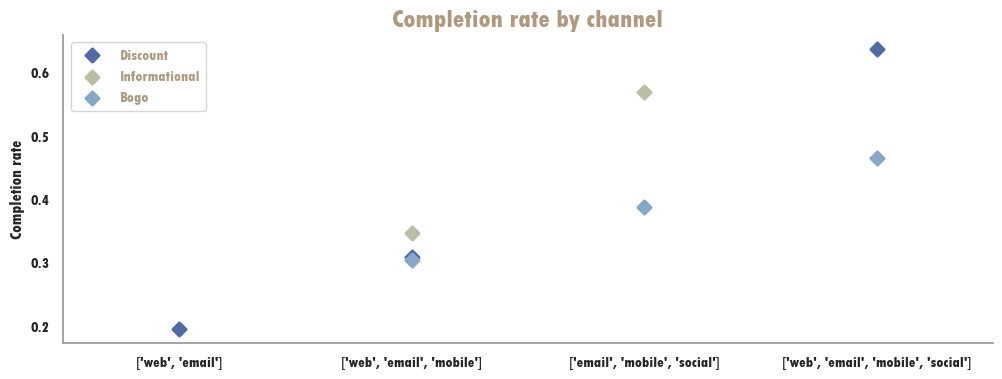

In [137]:
fig, ax = plt.subplots(figsize = (12, 4))
g = plot_completion_by_categorical(offers_channel, "channels", "Completion rate by channel", width = 2, ax = ax)

g.set_title("Completion rate by channel", fontdict={'fontsize': 19})

plt.savefig("visualizations/completion_rate_by_channel.jpg", format = "jpg")

# Plotting model outcomes

In this section, first a data frame crossing all the values for the model categorical variables, and setting income at the average value of the validation set is construct

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import statsmodels.api as sm
import patsy


First, we need to fit the model

In [139]:
lg_interaction, formula, exog_train, exog_val, X_val, y_val = fit_logistic(offers, ["income_thousands", "gender", "young", "seniority", "social"], interaction = True)

Optimization terminated successfully.
         Current function value: 0.603956
         Iterations 5


In [140]:
lg_interaction.summary().tables[0]

Dep. Variable:,completed,No. Observations:,53200
Model:,Logit,Df Residuals:,53176
Method:,MLE,Df Model:,23
Date:,"Wed, 22 Mar 2023",Pseudo R-squ.:,0.1167
Time:,21:33:43,Log-Likelihood:,-32130.
converged:,True,LL-Null:,-36375.
Covariance Type:,nonrobust,LLR p-value:,0.000


In [141]:
pretty_coefficients(lg_interaction.summary(), exog_train)

,Variable,coef,odds ratio,z,P>|z|
0,Intercept,0.453,1.573,4.366,0.000
1,[T.Bogo],-1.990,0.137,-15.318,0.000
2,[T.Discount],-1.445,0.236,-11.078,0.000
3,gender[T.Male]:[Bogo],-0.339,0.712,-11.016,0.000
4,gender[T.Other]:[Bogo],0.472,1.603,3.660,0.000
5,gender[T.Male]:[Discount],-0.163,0.849,-4.973,0.000
6,gender[T.Other]:[Discount],0.403,1.496,2.929,0.003
7,gender[T.Male]:[Informational],-0.012,0.988,-0.270,0.787
8,gender[T.Other]:[Informational],0.178,1.194,1.038,0.299
9,young[T.True]:[Bogo],-0.326,0.722,-7.233,0.000


Now, we create a data frma crossing all the possible values for the categorical variables and, getting the average for the income variable in the validation set

In [142]:
new_data_grid = expand_grid(["Informational", "Bogo", "Discount"], 
            ["Male", "Female", "Other"], 
            [False, True], 
            ["Gen1", "Gen2", "Gen3"], 
            [False, True], 
            var_names = ["offer_type", "gender", "young", "seniority", "social"])

# exog_val contains an array with the elements of the income in three different columns (one for each offer type)
average_income_val = np.mean(np.sum(np.asarray(exog_val)[:, 21:24], axis = 1))
new_data_grid['income_thousands'] = average_income_val

new_exog_df = patsy.dmatrix(formula, data = new_data_grid)
preds = lg_interaction.predict(new_exog_df)

new_data_grid['preds'] = preds
new_data_grid.sort_values("preds", ascending = False)

,offer_type,gender,young,seniority,social,income_thousands,preds
99,Discount,Other,False,Gen2,True,65.403804,0.853370
97,Discount,Other,False,Gen1,True,65.403804,0.837309
105,Discount,Other,True,Gen2,True,65.403804,0.802146
87,Discount,Female,False,Gen2,True,65.403804,0.795529
103,Discount,Other,True,Gen1,True,65.403804,0.781909
...,...,...,...,...,...,...,...
88,Discount,Female,False,Gen3,False,65.403804,0.168844
76,Discount,Male,False,Gen3,False,65.403804,0.147137
46,Bogo,Male,True,Gen3,False,65.403804,0.144755
94,Discount,Female,True,Gen3,False,65.403804,0.123970


In [143]:
new_data_grid.head()

,offer_type,gender,young,seniority,social,income_thousands,preds
0,Informational,Male,False,Gen1,False,65.403804,0.427627
1,Informational,Male,False,Gen1,True,65.403804,0.662587
2,Informational,Male,False,Gen2,False,65.403804,0.434406
3,Informational,Male,False,Gen2,True,65.403804,0.668739
4,Informational,Male,False,Gen3,False,65.403804,0.253068


In [144]:
preds_df = new_data_grid.groupby("offer_type").apply(lambda x: x.sort_values('preds', ascending = False).head(30))
preds_df['channel'] = preds_df.social.apply(lambda x: "Social" if x == True else "Other channels")
preds_df['age_group'] = preds_df.young.apply(lambda x: "Younger than 35" if x == True else "35 or older")
preds_df['gender'] = preds_df.gender.apply(lambda x: "Other gender" if x == "Other" else x)
preds_df['group'] = preds_df.gender.str.cat([preds_df.age_group, preds_df.seniority, preds_df.channel], sep = "|")
preds_df = preds_df.drop("offer_type", axis = 1)

preds_df.reset_index(inplace = True)

val_grouped = X_val.value_counts(["offer_type", "gender", "young", "seniority", "social"]).reset_index()
val_grouped['channel'] = val_grouped.social.apply(lambda x: "Social" if x == True else "Other channels")
val_grouped['age_group'] = val_grouped.young.apply(lambda x: "Younger than 35" if x == True else "35 or older")
val_grouped['gender'] = val_grouped.gender.apply(lambda x: "Other gender" if x == "Other" else x)
val_grouped.drop("social", axis = 1, inplace = True)
val_grouped.rename(columns = {0: "n_offers"}, inplace = True)

In [145]:
preds_df.head()

,offer_type,level_1,gender,young,seniority,social,income_thousands,preds,channel,age_group,group
0,Bogo,63,Other gender,False,Gen2,True,65.403804,0.737530,Social,35 or older,Other gender|35 or older|Gen2|Social
1,Bogo,69,Other gender,True,Gen2,True,65.403804,0.669716,Social,Younger than 35,Other gender|Younger than 35|Gen2|Social
2,Bogo,51,Female,False,Gen2,True,65.403804,0.636715,Social,35 or older,Female|35 or older|Gen2|Social
3,Bogo,62,Other gender,False,Gen2,False,65.403804,0.596952,Other channels,35 or older,Other gender|35 or older|Gen2|Other channels
4,Bogo,61,Other gender,False,Gen1,True,65.403804,0.571722,Social,35 or older,Other gender|35 or older|Gen1|Social


In [146]:
preds_df = preds_df.merge(val_grouped, on = ["offer_type", "gender", "young", "seniority", "channel", "age_group"])

In [147]:
preds_df.head()

,offer_type,level_1,gender,young,seniority,social,income_thousands,preds,channel,age_group,group,n_offers
0,Bogo,63,Other gender,False,Gen2,True,65.403804,0.737530,Social,35 or older,Other gender|35 or older|Gen2|Social,19
1,Bogo,69,Other gender,True,Gen2,True,65.403804,0.669716,Social,Younger than 35,Other gender|Younger than 35|Gen2|Social,1
2,Bogo,51,Female,False,Gen2,True,65.403804,0.636715,Social,35 or older,Female|35 or older|Gen2|Social,695
3,Bogo,62,Other gender,False,Gen2,False,65.403804,0.596952,Other channels,35 or older,Other gender|35 or older|Gen2|Other channels,12
4,Bogo,61,Other gender,False,Gen1,True,65.403804,0.571722,Social,35 or older,Other gender|35 or older|Gen1|Social,2


In [148]:
offers.groupby("offer_type").agg({"completed": "mean"})

,completed
offer_type,
Bogo,0.405585
Discount,0.444532
Informational,0.458421


Now it's time to plot the probabilities for each group

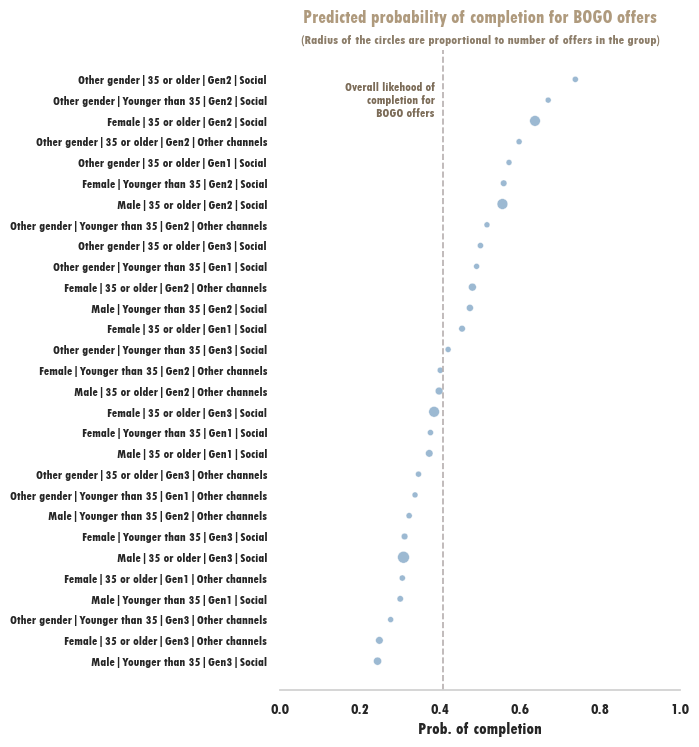

In [149]:
plot_prediction_groups(preds_df, "Bogo", 0.406)
plt.savefig("visualizations/probability_groups_point_bogo2.jpg", format = "jpg")

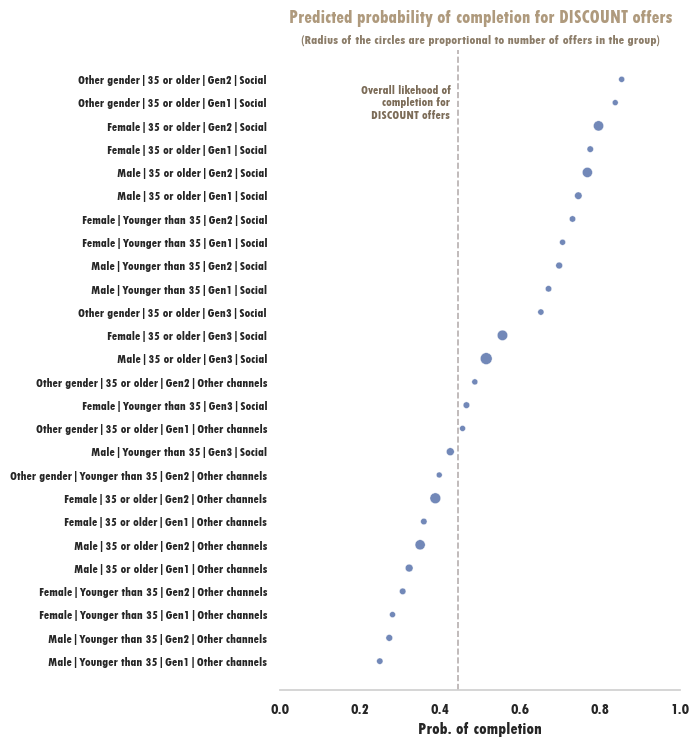

In [150]:
plot_prediction_groups(preds_df, "Discount", 0.445)
plt.savefig("visualizations/probability_groups_point_discount.jpg", format = "jpg")

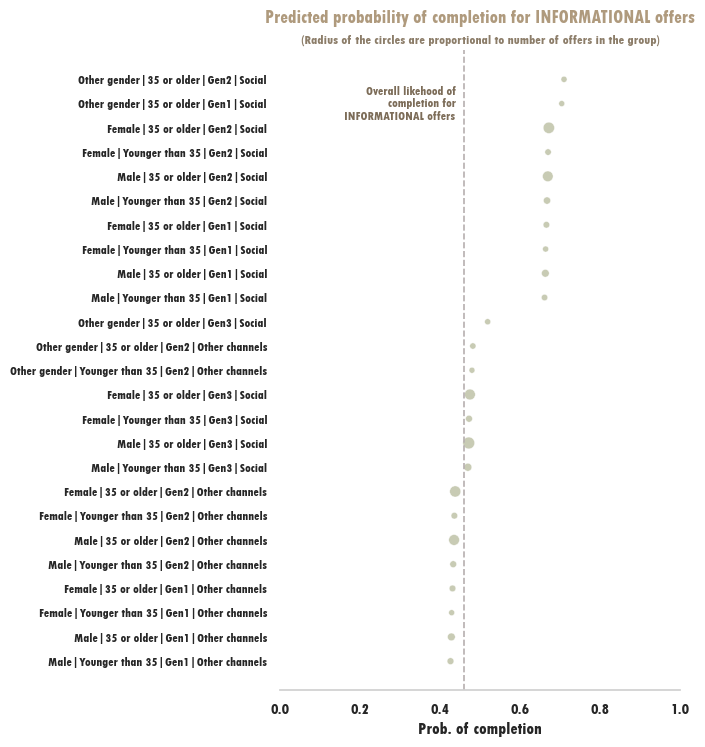

In [151]:
plot_prediction_groups(preds_df, "Informational", 0.458)
plt.savefig("visualizations/probability_groups_point_informational.jpg", format = "jpg")